In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [60]:
# Imports
from os import makedirs
from os import listdir
from os.path import join
import pandas as pd
import numpy as np
import joblib
from nltk.corpus import wordnet as wn
from scipy.stats import pearsonr
from tqdm.auto import tqdm
from IPython.display import display, HTML
from matplotlib import pyplot as plt

rng_seed = 399
np.random.seed(rng_seed)

# Directory constants
topological_data_analysis_data_dir = "data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
topological_polysemy_experimentation_dir = join(
    output_dir, "topological_polysemy_experimentation"
)
word_embeddings_data_dir = join(root_code_dir, "word_embeddings", "data")
output_plots_dir = join("output_plots")
makedirs(output_plots_dir, exist_ok=True)

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from word_embeddings.word2vec import load_model_training_output
from vis_utils import configure_plotting_for_thesis

configure_plotting_for_thesis()

Plots configured for thesis!


<IPython.core.display.Javascript object>

## Set up data and constants

In [3]:
# Load SemEval data
semeval_2010_14_word_senses = joblib.load(
    join(topological_data_analysis_data_dir, "semeval_2010_14_word_senses.joblib")
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))

<IPython.core.display.Javascript object>

In [4]:
# Constants
should_prepare_tps_experiment_values = False
tps_neighbourhood_sizes = [10, 40, 50, 60, 100]
tps_word_embeddings_names = [
    "enwiki",
    "semeval_2010_task_14",
    "fasttext_cc_300d",
    "glove_cc_840b_300d",
    "google_news_3m",
]
tps_word_embeddings_model_names = [
    "enwiki",
    "semeval_2010_task_14",
    "cc.en.300.vec",
    "glove.840B.300d",
    "GoogleNews-vectors-negative300",
]
tps_word_embeddings_is_external = [False, False, True, True, True]
tps_word_embeddings_paths = [
    join(word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"),
    join(word2vec_training_dir, "word2vec_semeval_2010_task_14"),
    join(word_embeddings_data_dir, "fastText"),
    join(word_embeddings_data_dir, "GloVe"),
    join(word_embeddings_data_dir, "GoogleNews"),
]
tps_vs_gs_key = "TPS_n vs. GS"
tps_vs_synsets_key = "TPS_n vs. synsets"
tps_vs_frequency_key = "TPS_n vs. frequency"
num_top_k_words_frequencies = 10000

<IPython.core.display.Javascript object>

## Prepare TPS experiment table values

In [5]:
tps_experiment_table_dicts = []
tps_experiment_table_col_sizes_dicts = []
tps_experiment_table_values = []
if should_prepare_tps_experiment_values:
    for (
        word_embeddings_name,
        word_embeddings_model_name,
        word_embeddings_path,
        word_embeddings_is_external,
    ) in zip(
        tps_word_embeddings_names,
        tps_word_embeddings_model_names,
        tps_word_embeddings_paths,
        tps_word_embeddings_is_external,
    ):
        # Load data
        if word_embeddings_is_external:
            print(f"Loading {word_embeddings_name} word embeddings words...")
            model_words_filepath = join(
                word_embeddings_path, f"{word_embeddings_model_name}_words.txt"
            )
            with open(model_words_filepath, "r") as words_file:
                model_words = np.array(words_file.read().split("\n"))
            word_to_int = {word: i for i, word in enumerate(model_words)}
        else:
            print(f"Loading {word_embeddings_name} word embeddings...")
            w2v_training_output = load_model_training_output(
                model_training_output_dir=word_embeddings_path,
                model_name="word2vec",
                dataset_name=word_embeddings_model_name,
            )
            model_words = w2v_training_output["words"]
            word_to_int = w2v_training_output["word_to_int"]
            word_counts = w2v_training_output["word_counts"]
            print("Done!")
        col_sizes_result_dict = {}
        values_dict = {}

        # Filter SemEval words in vocabulary
        semeval_target_words_in_vocab_filter = [
            i for i, word in enumerate(semeval_target_words) if word in word_to_int
        ]
        semeval_gs_clusters_in_vocab = semeval_gs_clusters[
            semeval_target_words_in_vocab_filter
        ]
        col_sizes_result_dict[tps_vs_gs_key] = len(semeval_gs_clusters_in_vocab)

        # Find words in vocabulary that have synsets in Wordnet
        wordnet_synsets_words_in_vocab_meanings = []
        print("Find words in vocabulary that have synsets in Wordnet...")
        for word in tqdm(model_words):
            num_synsets_word = len(wn.synsets(word))
            if num_synsets_word > 0:
                wordnet_synsets_words_in_vocab_meanings.append(num_synsets_word)
        col_sizes_result_dict[tps_vs_synsets_key] = len(
            wordnet_synsets_words_in_vocab_meanings
        )

        # Set values dict
        values_dict = {
            "semeval": semeval_gs_clusters_in_vocab,
            "synsets": wordnet_synsets_words_in_vocab_meanings,
        }
        if not word_embeddings_is_external:
            values_dict["frequencies"] = word_counts[:num_top_k_words_frequencies]

        result_dict: dict = {
            "n": tps_neighbourhood_sizes,
            tps_vs_gs_key: [],
            tps_vs_synsets_key: [],
        }
        if not word_embeddings_is_external:
            result_dict[tps_vs_frequency_key] = []

        # Fill in dictionary
        for n_size in tps_neighbourhood_sizes:

            # TPS_n score vs. GS
            tps_scores_semeval = np.load(
                join(
                    topological_polysemy_experimentation_dir,
                    word_embeddings_name,
                    f"tps_{n_size}_vs_gs.npy",
                )
            )
            values_dict[f"tps_{n_size}_vs_gs"] = tps_scores_semeval
            tps_score_vs_gs_correlation, _ = pearsonr(
                x=tps_scores_semeval, y=semeval_gs_clusters_in_vocab
            )
            result_dict[tps_vs_gs_key].append(tps_score_vs_gs_correlation)

            # TPS_n score vs. Synsets
            tps_scores_wordnet_synsets = np.load(
                join(
                    topological_polysemy_experimentation_dir,
                    word_embeddings_name,
                    f"tps_{n_size}_vs_synsets.npy",
                )
            )
            values_dict[f"tps_{n_size}_vs_synsets"] = tps_scores_wordnet_synsets
            tps_score_vs_wordnet_synsets_correlation, _ = pearsonr(
                x=tps_scores_wordnet_synsets, y=wordnet_synsets_words_in_vocab_meanings
            )
            result_dict[tps_vs_synsets_key].append(
                tps_score_vs_wordnet_synsets_correlation
            )

            # TPS_n score vs. frequency
            if not word_embeddings_is_external:
                tps_score_word_frequencies = np.load(
                    join(
                        topological_polysemy_experimentation_dir,
                        word_embeddings_name,
                        f"tps_{n_size}_vs_frequency.npy",
                    )
                )
                values_dict[f"tps_{n_size}_vs_frequency"] = tps_score_word_frequencies
                tps_score_vs_word_frequency_correlation, _ = pearsonr(
                    x=tps_score_word_frequencies,
                    y=word_counts[:num_top_k_words_frequencies],
                )
                result_dict[tps_vs_frequency_key].append(
                    tps_score_vs_word_frequency_correlation
                )
                col_sizes_result_dict[tps_vs_frequency_key] = len(
                    tps_score_word_frequencies
                )
        tps_experiment_table_dicts.append(result_dict)
        tps_experiment_table_col_sizes_dicts.append(col_sizes_result_dict)
        tps_experiment_table_values.append(values_dict)

        # Free resources
        del wordnet_synsets_words_in_vocab_meanings
        if word_embeddings_is_external:
            del model_words
            del word_to_int
        else:
            del w2v_training_output
            del model_words
            del word_to_int
            del word_counts

    # Cache result
    joblib.dump(
        tps_experiment_table_dicts,
        join(topological_data_analysis_data_dir, "tps_experiment_table_dicts.joblib"),
        protocol=4,
    )
    joblib.dump(
        tps_experiment_table_col_sizes_dicts,
        join(
            topological_data_analysis_data_dir,
            "tps_experiment_table_col_sizes_dicts.joblib",
        ),
        protocol=4,
    )
    joblib.dump(
        tps_experiment_table_values,
        join(topological_data_analysis_data_dir, "tps_experiment_table_values.joblib"),
        protocol=4,
    )
else:

    # Load cached result
    tps_experiment_table_dicts = joblib.load(
        join(topological_data_analysis_data_dir, "tps_experiment_table_dicts.joblib")
    )
    tps_experiment_table_col_sizes_dicts = joblib.load(
        join(
            topological_data_analysis_data_dir,
            "tps_experiment_table_col_sizes_dicts.joblib",
        )
    )
    tps_experiment_table_values = joblib.load(
        join(topological_data_analysis_data_dir, "tps_experiment_table_values.joblib")
    )

<IPython.core.display.Javascript object>

## Visualize tables

In [6]:
pd.set_option("display.precision", 3)
for name, table_dict, col_sizes_dict in zip(
    tps_word_embeddings_names,
    tps_experiment_table_dicts,
    tps_experiment_table_col_sizes_dicts,
):
    print(f"-- {name} --")
    table_df = pd.DataFrame(table_dict)
    table_df.set_index("n", inplace=True)
    display(HTML(table_df.to_html()))
    print(col_sizes_dict)

-- enwiki --


,TPS_n vs. GS,TPS_n vs. synsets,TPS_n vs. frequency
n,,,
10,-0.353,-0.077,-0.043
40,-0.383,-0.181,-0.041
50,-0.380,-0.190,-0.041
60,-0.381,-0.196,-0.040
100,-0.380,-0.205,-0.033


{'TPS_n vs. GS': 98, 'TPS_n vs. synsets': 144412, 'TPS_n vs. frequency': 10000}
-- semeval_2010_task_14 --


,TPS_n vs. GS,TPS_n vs. synsets,TPS_n vs. frequency
n,,,
10,-0.300,-0.248,0.102
40,-0.201,-0.300,0.120
50,-0.194,-0.304,0.116
60,-0.169,-0.306,0.110
100,-0.130,-0.310,0.098


{'TPS_n vs. GS': 100, 'TPS_n vs. synsets': 62111, 'TPS_n vs. frequency': 10000}
-- fasttext_cc_300d --


,TPS_n vs. GS,TPS_n vs. synsets
n,,
10,-0.240,0.114
40,-0.289,0.110
50,-0.199,0.108
60,-0.150,0.105
100,-0.105,0.099


{'TPS_n vs. GS': 100, 'TPS_n vs. synsets': 230175}
-- glove_cc_840b_300d --


,TPS_n vs. GS,TPS_n vs. synsets
n,,
10,-0.103,0.008
40,-0.125,-0.039
50,-0.053,-0.044
60,-0.023,-0.048
100,-0.053,-0.058


{'TPS_n vs. GS': 100, 'TPS_n vs. synsets': 249352}
-- google_news_3m --


,TPS_n vs. GS,TPS_n vs. synsets
n,,
10,-0.446,-0.095
40,-0.446,-0.166
50,-0.436,-0.174
60,-0.428,-0.180
100,-0.417,-0.193


{'TPS_n vs. GS': 100, 'TPS_n vs. synsets': 207119}


<IPython.core.display.Javascript object>

## Create plots for thesis

In [48]:
# Prepare data
selected_n_for_plots = {
    "enwiki": {
        "semeval": 40,
        "synsets": 100,
        "frequencies": 10,
    },
    "semeval_2010_task_14": {
        "semeval": 10,
        "synsets": 100,
        "frequencies": 40,
    },
}

<IPython.core.display.Javascript object>

-- enwiki --
100
-- semeval_2010_task_14 --
100


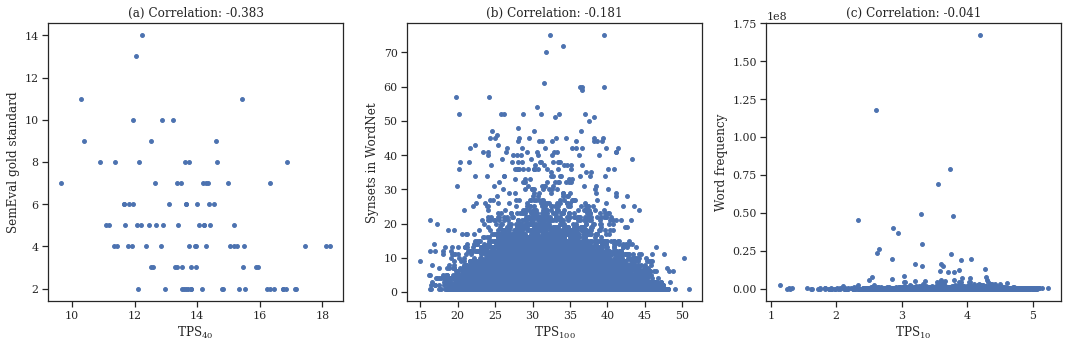

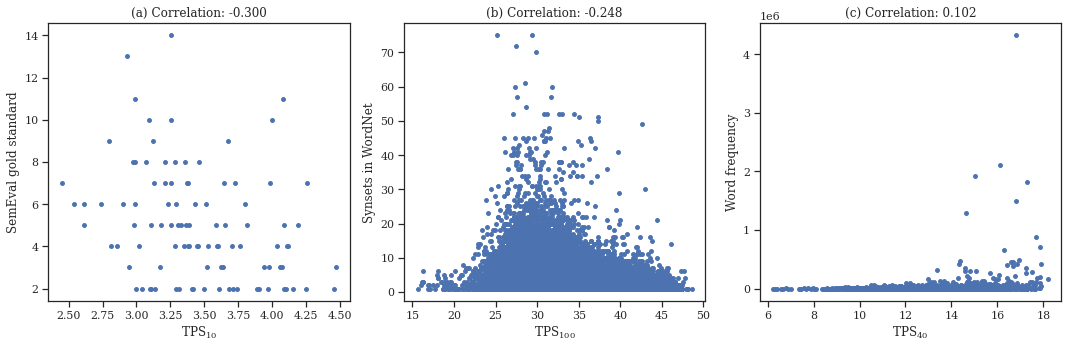

<IPython.core.display.Javascript object>

In [67]:
for (word_embeddings_name, selected_ns), tps_experiment_table_value in zip(
    selected_n_for_plots.items(), tps_experiment_table_values
):
    print(f"-- {word_embeddings_name} --")

    # Parse selected neighbourhood values
    semeval_ns = selected_ns["semeval"]
    synsets_ns = selected_ns["synsets"]
    frequencies_ns = selected_ns["frequencies"]

    # Create plots
    _, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(5 * 3, 5))

    tps_score_vs_gs_correlation, _ = pearsonr(
        x=tps_experiment_table_value[f"tps_{semeval_ns}_vs_gs"],
        y=tps_experiment_table_value["semeval"],
    )
    ax1.scatter(
        x=tps_experiment_table_value[f"tps_{semeval_ns}_vs_gs"],
        y=tps_experiment_table_value["semeval"],
        s=15,
    )
    ax1.set_xlabel("TPS" + r"$_{" + str(semeval_ns) + "}$")
    ax1.set_ylabel("SemEval gold standard")
    ax1.set_title(f"(a) Correlation: {tps_score_vs_gs_correlation:.3f}")

    tps_score_vs_synsets_correlation, _ = pearsonr(
        x=tps_experiment_table_value[f"tps_{semeval_ns}_vs_synsets"],
        y=tps_experiment_table_value["synsets"],
    )
    ax2_handle = ax2.scatter(
        x=tps_experiment_table_value[f"tps_{synsets_ns}_vs_synsets"],
        y=tps_experiment_table_value["synsets"],
        s=15,
    )
    ax2_handle.set_rasterized(True)
    ax2.set_xlabel("TPS" + r"$_{" + str(synsets_ns) + "}$")
    ax2.set_ylabel("Synsets in WordNet")
    ax2.set_title(f"(b) Correlation: {tps_score_vs_synsets_correlation:.3f}")

    tps_score_vs_frequencies_correlation, _ = pearsonr(
        x=tps_experiment_table_value[f"tps_{semeval_ns}_vs_frequency"],
        y=tps_experiment_table_value["frequencies"],
    )
    ax3_handle = ax3.scatter(
        x=tps_experiment_table_value[f"tps_{frequencies_ns}_vs_frequency"],
        y=tps_experiment_table_value["frequencies"],
        s=15,
    )
    ax3_handle.set_rasterized(True)
    ax3.set_xlabel("TPS" + r"$_{" + str(frequencies_ns) + "}$")
    ax3.set_ylabel("Word frequency")
    ax3.set_title(f"(c) Correlation: {tps_score_vs_frequencies_correlation:.3f}")

    # Plot/save
    save_to_pgf = True
    plt.tight_layout()
    if save_to_pgf:
        plt.savefig(
            join(
                output_plots_dir,
                f"tps-n-correlation-sgns-{word_embeddings_name}.pdf",
            ),
            backend="pgf",
        )
    else:
        plt.show()